In [1]:
%pylab inline
import pandas as pd
import h5py as h5
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist

Populating the interactive namespace from numpy and matplotlib


# HW4 - Clustering Panel Demographics

The goal is to see if any clusters exist for panelists who have purchased any yogurt.

### Load Data

In [2]:
datafile = '../Final/yogurt.h5'

In [3]:
with h5.File(datafile,'r') as hf:
    print hf.keys()

[u'delivery_stores', u'demos', u'drug', u'groc', u'panel']


In [4]:
panel = pd.read_hdf(datafile,'panel')
demo = pd.read_hdf(datafile,'demos')

In [5]:
print panel.columns, '\n',demo.columns
print len(panel), len(demo)

Index([u'COLUPC', u'DOLLARS', u'IRI_KEY', u'MINUTE', u'OUTLET', u'PANID',
       u'UNITS', u'WEEK', u'file'],
      dtype='object') 
Index([u'ALL_TVS', u'Age Group Applied to Female HH',
       u'Age Group Applied to Male HH', u'CABL_TVS', u'COUNTY',
       u'Children Group Code', u'Combined Pre-Tax Income of HH', u'EXT_FACT',
       u'Education Level Reached by Female HH',
       u'Education Level Reached by Male HH', u'FIPSCODE', u'Family Size',
       u'Female Working Hour Code', u'HH_AGE', u'HH_EDU', u'HH_OCC',
       u'HH_RACE', u'IRI Geography Number', u'Language',
       u'Male Working Hour Code', u'Marital Status', u'Number of Cats',
       u'Number of Dogs', u'Occupation Code of Female HH',
       u'Occupation Code of Male HH', u'Panelist ID', u'RACE3',
       u'Type of Residential Possession', u'Year', u'ZIPCODE', u'filename',
       u'yearID'],
      dtype='object')
1609107 74592


### Data Prep and Cleaning

In this step, we clean the data and remove unwanted columns. Nominal data is binarized and numerical data is normalized.

In [6]:
# get only panelists who have purchased yogurt
data = pd.merge(panel[['PANID']].drop_duplicates(), demo, how='right', left_on='PANID', right_on='Panelist ID')[demo.columns]

In [7]:
counts = (data.describe().iloc[0,:]/float(data.shape[0])).round(2)

# find features with missing data
counts[counts < 1].sort_values()

Language                0.28
EXT_FACT                0.63
FIPSCODE                0.63
HH_AGE                  0.63
HH_EDU                  0.63
HH_OCC                  0.63
IRI Geography Number    0.63
RACE3                   0.63
ZIPCODE                 0.63
CABL_TVS                0.73
ALL_TVS                 0.77
HH_RACE                 0.99
Name: count, dtype: float64

In [8]:
# show counts by year of data available for missing columns
missing_counts = data.groupby('yearID')[counts[counts < 1].keys().tolist()].count()
missing_counts

,ALL_TVS,CABL_TVS,EXT_FACT,FIPSCODE,HH_AGE,HH_EDU,HH_OCC,HH_RACE,IRI Geography Number,Language,RACE3,ZIPCODE
yearID,,,,,,,,,,,,
1,5609,5442,0,0,0,0,0,13983,0,0,0,0
2,5575,5402,0,0,0,0,0,13887,0,0,0,0
3,6434,6406,6565,6565,6565,6565,6565,6423,6565,729,6565,6565
4,5816,5769,5907,5907,5907,5907,5907,5807,5907,676,5907,5907
5,5673,5608,5743,5743,5743,5743,5743,5665,5743,653,5743,5743
6,5507,5395,5566,5566,5566,5566,5566,5500,5566,637,5566,5566
7,4998,4908,5041,5041,5041,5041,5041,4993,5041,616,5041,5041
8,4830,4327,4861,4861,4827,4828,4827,4861,4861,4861,4861,4861
9,4586,4071,4607,4607,4585,4586,4585,4607,4607,4607,4607,4607


In [9]:
# get total rows for each year
year_counts = data.groupby('yearID')['yearID'].count()
year_counts

yearID
1     13983
2     13887
3      6565
4      5907
5      5743
6      5566
7      5041
8      4861
9      4607
10     4261
11     4171
Name: yearID, dtype: int64

In [10]:
# find out how much of the data is missing by year
missing_counts.apply(lambda x: x.divide(year_counts)).round(2)

,ALL_TVS,CABL_TVS,EXT_FACT,FIPSCODE,HH_AGE,HH_EDU,HH_OCC,HH_RACE,IRI Geography Number,Language,RACE3,ZIPCODE
yearID,,,,,,,,,,,,
1,0.40,0.39,0.0,0.0,0.00,0.00,0.00,1.00,0.0,0.00,0.0,0.0
2,0.40,0.39,0.0,0.0,0.00,0.00,0.00,1.00,0.0,0.00,0.0,0.0
3,0.98,0.98,1.0,1.0,1.00,1.00,1.00,0.98,1.0,0.11,1.0,1.0
4,0.98,0.98,1.0,1.0,1.00,1.00,1.00,0.98,1.0,0.11,1.0,1.0
5,0.99,0.98,1.0,1.0,1.00,1.00,1.00,0.99,1.0,0.11,1.0,1.0
6,0.99,0.97,1.0,1.0,1.00,1.00,1.00,0.99,1.0,0.11,1.0,1.0
7,0.99,0.97,1.0,1.0,1.00,1.00,1.00,0.99,1.0,0.12,1.0,1.0
8,0.99,0.89,1.0,1.0,0.99,0.99,0.99,1.00,1.0,1.00,1.0,1.0
9,1.00,0.88,1.0,1.0,1.00,1.00,1.00,1.00,1.0,1.00,1.0,1.0


In [11]:
# drop uninteresting columns, exclude year 1 and 2 due to missing data, drop rows with NaN
drop_columns = ['ZIPCODE',
                'FIPSCODE',
                'COUNTY',
                'IRI Geography Number', 
                'Language',
                'EXT_FACT',
                'Occupation Code of Male HH',
                'Occupation Code of Female HH',
                'HH_OCC',
                'HH_EDU',
                'HH_RACE',
                'HH_AGE',
                'yearID',
                'filename',
                'Year']

data = data[data.yearID >2].dropna().drop(drop_columns, axis='columns', errors='ignore')

data.columns

Index([u'ALL_TVS', u'Age Group Applied to Female HH',
       u'Age Group Applied to Male HH', u'CABL_TVS', u'Children Group Code',
       u'Combined Pre-Tax Income of HH',
       u'Education Level Reached by Female HH',
       u'Education Level Reached by Male HH', u'Family Size',
       u'Female Working Hour Code', u'Male Working Hour Code',
       u'Marital Status', u'Number of Cats', u'Number of Dogs', u'Panelist ID',
       u'RACE3', u'Type of Residential Possession'],
      dtype='object')

In [12]:
cleaned = data.copy()
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18857 entries, 11 to 74587
Data columns (total 17 columns):
ALL_TVS                                 18857 non-null float64
Age Group Applied to Female HH          18857 non-null int64
Age Group Applied to Male HH            18857 non-null int64
CABL_TVS                                18857 non-null float64
Children Group Code                     18857 non-null int64
Combined Pre-Tax Income of HH           18857 non-null float64
Education Level Reached by Female HH    18857 non-null int64
Education Level Reached by Male HH      18857 non-null int64
Family Size                             18857 non-null int64
Female Working Hour Code                18857 non-null int64
Male Working Hour Code                  18857 non-null int64
Marital Status                          18857 non-null int64
Number of Cats                          18857 non-null int64
Number of Dogs                          18857 non-null int64
Panelist ID                   

In [13]:
# mappings for standardized nominal data
age_dict = {0: 'N/A', 
                  1: '18-24',
                  2: '25-34',
                  3: '35-44',
                  4: '45-54',
                  5: '55-64',
                  6: '65 +',
                  7: 'No such person'}

edu_dict = {0: 'N/A', 
            1: 'Some grade school or less',
            2: 'Completed grade school',
            3: 'Some high school',
            4: 'Graduated high school',
            5: 'Technical school',
            6: 'Some college',
            7: 'Graduated from college',
            8: 'Post graduate work',
            9: 'No such head of household'}

pre_tax_income_dict = {0: 'N/A',
                  1: '$00,000 to $ 9,999 per yr',
                  2: '$10,000 to $11,999 per yr',
                  3: '$12,000 to $14,999 per yr',
                  4: '$15,000 to $19,999 per yr',
                  5: '$20,000 to $24,999 per yr',
                  6: '$25,000 to $34,999 per yr',
                  7: '$35,000 to $44,999 per yr',
                  8: '$45,000 to $54,999 per yr',
                  9: '$55,000 to $64,999 per yr',
                  10: '$65,000 to $74,999 per yr', 
                  11: '$75,000 to $99,999 per yr', 
                  12: '$100,000 and greater per year'}

working_hour_dict = {0: 'N/A', 
                     1: 'Not employed',
                     2: 'Part time, < 35 hrs./wk.',
                     3: 'Full time, > 35 hrs./wk.',
                     4: 'Retired',
                     5: 'Homemaker',
                     6: 'Some college',
                     7: 'N/A'}

marital_status_dict = {0: 'N/A',
                       1: 'Single',
                       2: 'Married',
                       3: 'Divorced',
                       4: 'Widowed',
                       5: 'Separated'}

child_group_dict = {0: 'N/A',
                    1: 'Child in [0-5)',
                    2: 'Child in [6-11)',
                    3: 'Child in [12-17)',
                    4: 'Children in [0-5) & [6-11)',
                    5: 'Children in [0-5) & [12-17)', 
                    6: 'Children in [6-11) & [1217)',
                    7: 'Children in [0-5),[6-11) & [12-17)',
                    8: 'Family size>0 yet no children'}

residental_possession_dict = {0: 'N/A',
                              1: 'Renter',
                              2: 'Owner'}

race_dict = {0: 'N/A',
             1: 'White',
             2: 'Black-African American',
             3: 'Hispanic',
             4: 'Asian',
             5: 'Other',
             6: 'American Indian-Alaska Native',
             7: 'Native Hawaiian-Pacific Islands'}



In [14]:
def getValue(dictionary,key):
    # function to deal with nans and unidenified dictionary keys
    try:
        value = dictionary[key]
    except: 
        value = dictionary[0]
    return value

In [15]:
# apply mappings to standardized nominal data
cleaned['Age Group Applied to Female HH']= cleaned['Age Group Applied to Female HH'].apply(lambda x: age_dict[x] )
cleaned['Age Group Applied to Male HH']= cleaned['Age Group Applied to Male HH'].apply(lambda x: age_dict[x] )
cleaned['Education Level Reached by Female HH']= cleaned['Education Level Reached by Female HH'].apply(lambda x: getValue(edu_dict,x))
cleaned['Education Level Reached by Male HH']= cleaned['Education Level Reached by Male HH'].apply(lambda x: getValue(edu_dict,x))
cleaned['Combined Pre-Tax Income of HH']= cleaned['Combined Pre-Tax Income of HH'].apply(lambda x: getValue(pre_tax_income_dict,x))
cleaned['Male Working Hour Code']= cleaned['Male Working Hour Code'].apply(lambda x: getValue(working_hour_dict,x))
cleaned['Female Working Hour Code']= cleaned['Female Working Hour Code'].apply(lambda x: getValue(working_hour_dict,x))
cleaned['Marital Status']= cleaned['Marital Status'].apply(lambda x: getValue(marital_status_dict,x))
cleaned['Children Group Code']= cleaned['Children Group Code'].apply(lambda x: getValue(child_group_dict,x))
cleaned['Type of Residential Possession']= cleaned['Type of Residential Possession'].apply(lambda x: getValue(residental_possession_dict,x))
cleaned['RACE3'] = cleaned['RACE3'].apply(lambda x: getValue(race_dict,x))


In [16]:
# normalize numeric data
num_col = cleaned.dtypes[cleaned.dtypes <> 'object'].keys().tolist()
cleaned.loc[:,num_col] = cleaned[num_col].apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

# binarize nominal data
binarized = pd.get_dummies(cleaned)

In [17]:
binarized.columns

Index([u'ALL_TVS', u'CABL_TVS', u'Family Size', u'Number of Cats',
       u'Number of Dogs', u'Panelist ID',
       u'Age Group Applied to Female HH_18-24',
       u'Age Group Applied to Female HH_25-34',
       u'Age Group Applied to Female HH_35-44',
       u'Age Group Applied to Female HH_45-54',
       u'Age Group Applied to Female HH_55-64',
       u'Age Group Applied to Female HH_65 +',
       u'Age Group Applied to Female HH_N/A',
       u'Age Group Applied to Female HH_No such person',
       u'Age Group Applied to Male HH_18-24',
       u'Age Group Applied to Male HH_25-34',
       u'Age Group Applied to Male HH_35-44',
       u'Age Group Applied to Male HH_45-54',
       u'Age Group Applied to Male HH_55-64',
       u'Age Group Applied to Male HH_65 +',
       u'Age Group Applied to Male HH_N/A',
       u'Age Group Applied to Male HH_No such person',
       u'Children Group Code_Child in [0-5)',
       u'Children Group Code_Child in [12-17)',
       u'Children Group Code_Chil


## Kmeans Clustering

Perform K-means clustering. Use elbow curve to determine optimal number of clusters.

/Users/juliusremigio/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/juliusremigio/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/juliusremigio/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' inst

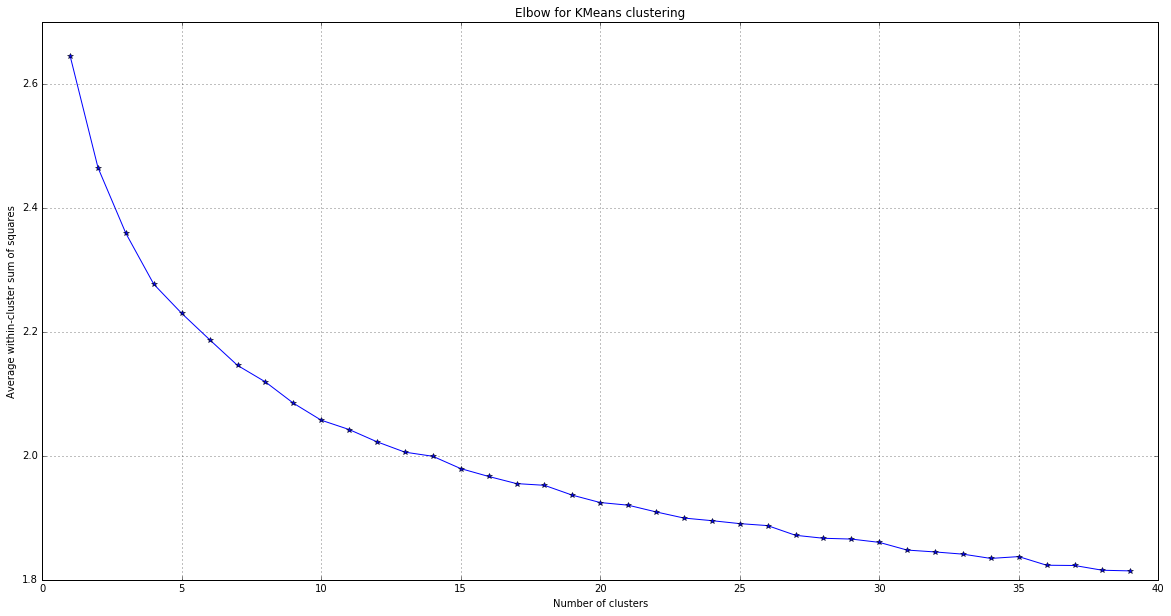

In [18]:
values = binarized.drop(['Panelist ID'],axis='columns').values

K = range(1,40)

KM = [KMeans(n_clusters=k, n_jobs=-1).fit(values) for k in K];
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(values, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/values.shape[0] for d in dist]

# elbow curve
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering');



It seems that betweeen 10-15 centroids are optimal for the data. There doesn't seem to be a distinct elbow, which may indicate that there the clusteres may not be well defined.

In [19]:
km = KMeans(n_clusters=12, n_jobs=-1)
km.fit(values)
clusters = km.predict(values)
centers = pd.DataFrame(km.cluster_centers_, columns=binarized.drop(['Panelist ID'],axis='columns').columns)

/Users/juliusremigio/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/juliusremigio/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/juliusremigio/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' inst

### K-Means - Clusters Descriptions

In [20]:
# unnormalize numerical data and assign predicted centroids to each data point
cleaned[num_col] = data[num_col]
cleaned['cluster'] = clusters

In [21]:
# group by centroids to analyze cluster features
grp_clusters = cleaned.groupby('cluster')
cluster_idx = grp_clusters[['Panelist ID']].count().sort_values('Panelist ID', ascending=False).reset_index().values

In [22]:
desc_col = cleaned.dtypes[~cleaned.dtypes.index.isin(['Panelist ID', 'cluster'])].keys()

# print cluster features
for idx, cnt in cluster_idx:
    print 'Cluster:', idx, 'Count:', cnt
    print grp_clusters.get_group(idx)[desc_col].describe(percentiles=list()).round(0).iloc[1, :], '\n'
    print grp_clusters.get_group(idx)[desc_col].describe(percentiles=list(), include=['object']).round(0).iloc[2, :], '\n'
    print '==========================================================='
#     break


Cluster: 4 Count: 2854
ALL_TVS           2.0
CABL_TVS          2.0
Family Size       3.0
Number of Cats    0.0
Number of Dogs    0.0
Name: mean, dtype: float64 

Age Group Applied to Female HH                                  55-64
Age Group Applied to Male HH                                    55-64
Children Group Code                     Family size>0 yet no children
Combined Pre-Tax Income of HH               $75,000 to $99,999 per yr
Education Level Reached by Female HH                 Some high school
Education Level Reached by Male HH                   Some high school
Female Working Hour Code                     Part time, < 35 hrs./wk.
Male Working Hour Code                       Part time, < 35 hrs./wk.
Marital Status                                                 Single
RACE3                                                           White
Type of Residential Possession                                 Renter
Name: top, dtype: object 

Cluster: 9 Count: 2566
ALL_TVS           

# Clustering - GMM

In [23]:
from sklearn.mixture import DPGMM

In [24]:
gmm = DPGMM(covariance_type='spherical',alpha=10000, n_iter=100)

gmm_clusters = gmm.fit_predict(values)

In [25]:
print gmm.converged_, gmm.n_components

True 1


In [26]:
cleaned['cluster_gmm'] = gmm_clusters
grp_clusters_gmm = cleaned.groupby('cluster_gmm')
gmm_cluster_idx = grp_clusters_gmm[['Panelist ID']].count().sort_values('Panelist ID', ascending=False).reset_index().values

In [27]:

for idx, cnt in gmm_cluster_idx:
    print 'Cluster:', idx, 'Count:', cnt
    print grp_clusters_gmm.get_group(idx)[desc_col].describe(percentiles=list()).round(0).iloc[1, :], '\n'
    print grp_clusters_gmm.get_group(idx)[desc_col].describe(percentiles=list(), include=['object']).round(0).iloc[2, :], '\n'
    print '==========================================================='
#     break

Cluster: 0 Count: 18857
ALL_TVS           2.0
CABL_TVS          2.0
Family Size       2.0
Number of Cats    0.0
Number of Dogs    0.0
Name: mean, dtype: float64 

Age Group Applied to Female HH                                   65 +
Age Group Applied to Male HH                           No such person
Children Group Code                     Family size>0 yet no children
Combined Pre-Tax Income of HH               $25,000 to $34,999 per yr
Education Level Reached by Female HH                 Some high school
Education Level Reached by Male HH                                N/A
Female Working Hour Code                     Full time, > 35 hrs./wk.
Male Working Hour Code                       Part time, < 35 hrs./wk.
Marital Status                                                 Single
RACE3                                                           White
Type of Residential Possession                                 Renter
Name: top, dtype: object 



It seems that the GMM is unable to find any meaningful clusters.

In [28]:
cleaned.columns

Index([u'ALL_TVS', u'Age Group Applied to Female HH',
       u'Age Group Applied to Male HH', u'CABL_TVS', u'Children Group Code',
       u'Combined Pre-Tax Income of HH',
       u'Education Level Reached by Female HH',
       u'Education Level Reached by Male HH', u'Family Size',
       u'Female Working Hour Code', u'Male Working Hour Code',
       u'Marital Status', u'Number of Cats', u'Number of Dogs', u'Panelist ID',
       u'RACE3', u'Type of Residential Possession', u'cluster',
       u'cluster_gmm'],
      dtype='object')

In [29]:
data.columns

Index([u'ALL_TVS', u'Age Group Applied to Female HH',
       u'Age Group Applied to Male HH', u'CABL_TVS', u'Children Group Code',
       u'Combined Pre-Tax Income of HH',
       u'Education Level Reached by Female HH',
       u'Education Level Reached by Male HH', u'Family Size',
       u'Female Working Hour Code', u'Male Working Hour Code',
       u'Marital Status', u'Number of Cats', u'Number of Dogs', u'Panelist ID',
       u'RACE3', u'Type of Residential Possession'],
      dtype='object')

In [30]:
panel.columns

Index([u'COLUPC', u'DOLLARS', u'IRI_KEY', u'MINUTE', u'OUTLET', u'PANID',
       u'UNITS', u'WEEK', u'file'],
      dtype='object')